In [1]:
# importing the required modules

import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.fft import fft, fftfreq, fftshift

In [13]:
# info about the data
trial = 1
sig_name = 'NEGRES19.CSV'
ref_name = 'NEGRES20.CSV'
sys_path = r'C:\Users\adhil\Documents\Github\Lockin_expeyes'
data_path = r'data\trial'

# importing the csv files
sig = csv.reader(open(f'{sys_path}\{data_path}{trial}\{sig_name}', 'r'))
ref = csv.reader(open(f'{sys_path}\{data_path}{trial}\{ref_name}', 'r'))

# extracting the data from the csv files
sig_data = []
ref_data = []
for row in sig:
    sig_data.append(row)
for row in ref:
    ref_data.append(row)

# converting the data to numpy arrays
sig_data = np.array(sig_data)
ref_data = np.array(ref_data)

In [14]:
print(sig_data)
print(sig_data.shape)

[['in s' 'C1 in V']
 ['-3.00001E+00' '1.922E-02']
 ['-2.99996E+00' '2.020E-02']
 ...
 ['2.99986E+00' '3.475E-02']
 ['2.99991E+00' '3.455E-02']
 ['2.99996E+00' '3.367E-02']]
(119049, 2)


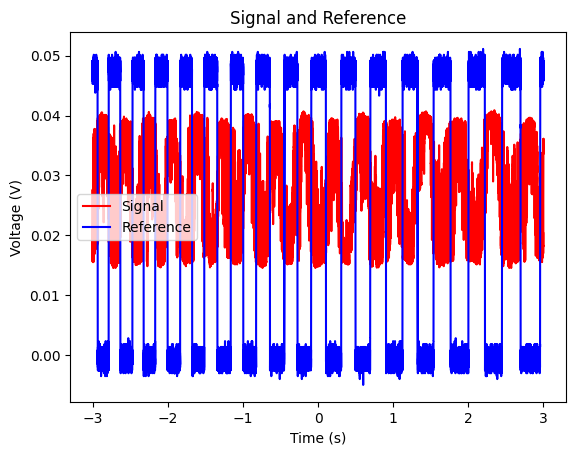

In [15]:
# N_sample = 25000
N_sample = sig_data.shape[0] - 1

sig_data = sig_data[1:N_sample + 1,:].astype(float)
sig_data = np.transpose(sig_data)
ref_data = ref_data[1:N_sample + 1,:].astype(float)
ref_data = np.transpose(ref_data)

# plotting the data
plt.plot(sig_data[0], sig_data[1], 'r', label='Signal')
plt.plot(ref_data[0], ref_data[1], 'b', label='Reference')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Signal and Reference')
plt.legend()
plt.show()

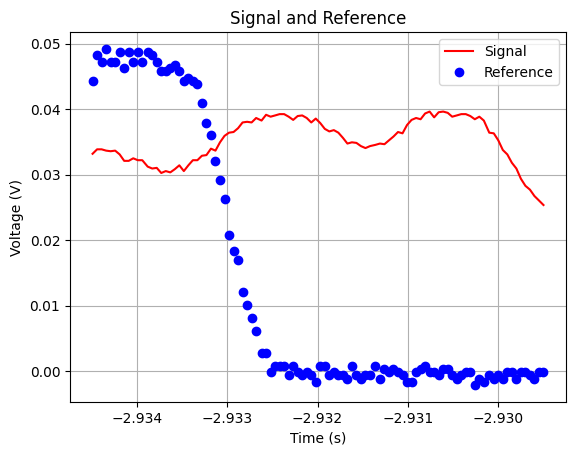

In [43]:
# plot the first 100 samples in detail
N_to_plot_start = 1300
N_to_plot_end = 1400
plt.plot(sig_data[0,N_to_plot_start:N_to_plot_end], sig_data[1,N_to_plot_start:N_to_plot_end], 'r', label='Signal')
plt.plot(ref_data[0,N_to_plot_start:N_to_plot_end], ref_data[1,N_to_plot_start:N_to_plot_end], 'bo', label='Reference')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Signal and Reference')
plt.legend()
plt.grid()
plt.show()

In [49]:
# finding the first rise index and further indices where reference signal gradiant changes

ref_sig_max = np.max(ref_data[1])
ref_sig_min = np.min(ref_data[1])

# centralizing the reference signal
ref_data[1] = ref_data[1] - ((ref_sig_max + ref_sig_min)/2)

first_rise_idx = 0
for i in range(1, N_sample):
    if ref_data[1][i] > 0 and ref_data[1][i-1] < 0:
        first_rise_idx = i
        break

ref_cross_idx = [first_rise_idx]
for i in range(first_rise_idx + 1, N_sample):
    if ref_data[1][i]*ref_data[1][i-1] < 0:
        ref_cross_idx.append(i)

triggered_sig = sig_data[1][first_rise_idx:]
triggered_ref = ref_data[1][first_rise_idx:]
triggered_time = sig_data[0][first_rise_idx:] - sig_data[0][first_rise_idx] # time starts from zero

ref_cross_idx = np.array(ref_cross_idx)
ref_cross_idx = ref_cross_idx - first_rise_idx # resetting the indices to start from zero

print(triggered_sig.shape)
print(triggered_ref.shape)
print(triggered_time.shape)
print(triggered_time)
print()
print(ref_cross_idx.shape)
print(ref_cross_idx)


(114795,)
(114795,)
(114795,)
[0.00000e+00 5.00000e-05 1.00000e-04 ... 5.78552e+00 5.78557e+00
 5.78562e+00]

(31,)
[     0   3079   6269   9217  12287  15529  18896  22012  25241  28666
  32233  35523  38935  42557  46333  49831  53469  57351  61408  65149
  69041  73207  77571  81596  85772  90264  94983  99332 103849 108738
 113905]


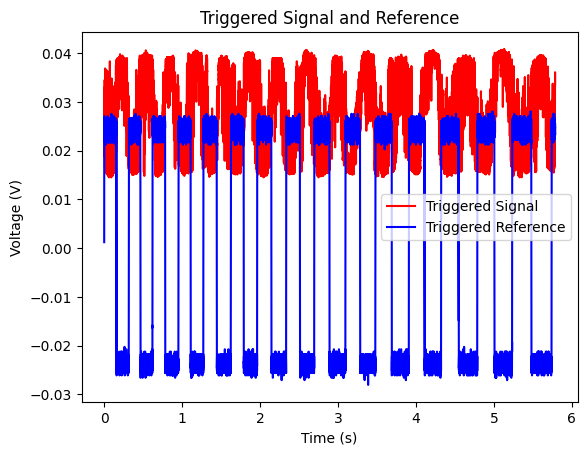

In [50]:
# plotting the triggered signals
plt.plot(triggered_time, triggered_sig, 'r', label='Triggered Signal')
plt.plot(triggered_time, triggered_ref, 'b', label='Triggered Reference')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Triggered Signal and Reference')
plt.legend()
plt.show()

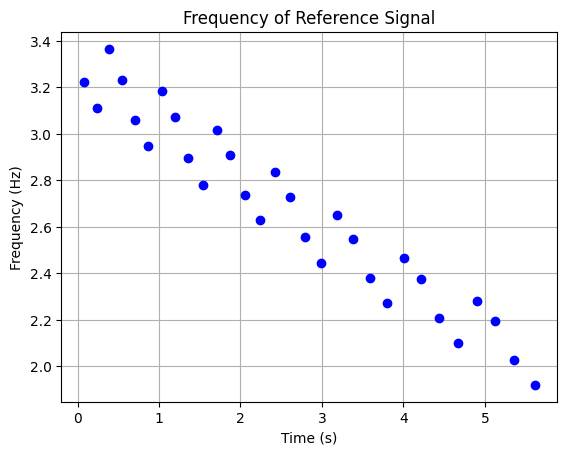

In [54]:
# finding the changing frequency of reference signal based on the zero crossings
N_cross = ref_cross_idx.shape[0]
time_period = np.zeros(N_cross - 1)
frequency = np.zeros(N_cross - 1)
time_of_frequency = np.zeros(N_cross - 1)

for i in range(N_cross - 1):
    time_period[i] = 2 * (triggered_time[ref_cross_idx[i+1]] - triggered_time[ref_cross_idx[i]])
    frequency[i] = 1/time_period[i]
    time_of_frequency[i] = (triggered_time[ref_cross_idx[i+1]] + triggered_time[ref_cross_idx[i]])/2
    
# plotting the frequency
plt.plot(time_of_frequency, frequency, 'bo')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency of Reference Signal')
plt.grid()
plt.show()

sus!


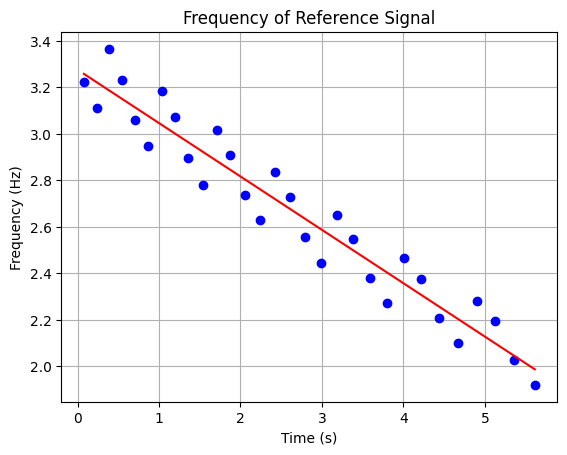

In [58]:
# fitting the frequency data with a 2nd degree polynomial
fit = np.polyfit(time_of_frequency, frequency, 1)
fit_fn = np.poly1d(fit)
plt.plot(time_of_frequency, frequency, 'bo', time_of_frequency, fit_fn(time_of_frequency), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency of Reference Signal')
plt.grid()
plt.show()

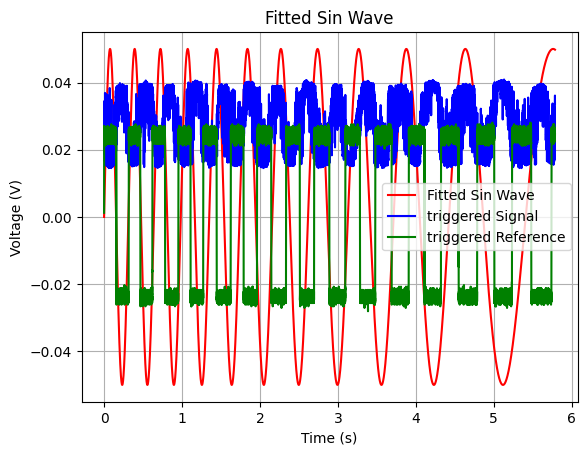

In [59]:
# using the fit_fn to find the frequency at each time step
fitted_frequency = fit_fn(triggered_time)

# using the fitted frequency to create a sin wave of the same frequency and amplitude 2
sin_wave = 0.05 * np.sin(2 * np.pi * fitted_frequency * triggered_time)

# plotting the sin wave
plt.plot(triggered_time, sin_wave, 'r', label='Fitted Sin Wave')
plt.plot(triggered_time, triggered_sig, 'b', label='triggered Signal')
plt.plot(triggered_time, triggered_ref, 'g', label='triggered Reference')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Fitted Sin Wave')
plt.legend()
plt.grid()
plt.show()


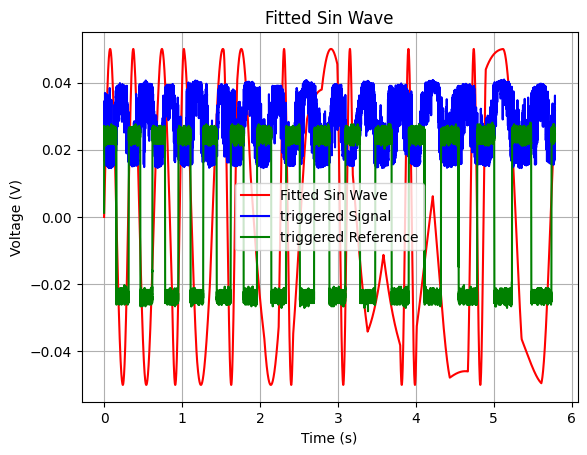

In [61]:
# alternate option to 'fit' the frequency is to make a linear intrapolation of the frequency data
# this is done by using the np.interp function
fitted_frequency = np.interp(triggered_time, time_of_frequency, frequency)

# plotting the new sine wave
sin_wave = 0.05 * np.sin(2 * np.pi * fitted_frequency * triggered_time)
plt.plot(triggered_time, sin_wave, 'r', label='Fitted Sin Wave')
plt.plot(triggered_time, triggered_sig, 'b', label='triggered Signal')
plt.plot(triggered_time, triggered_ref, 'g', label='triggered Reference')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Fitted Sin Wave')
plt.legend()
plt.grid()
plt.show()